In [9]:
import gc
import time
import numpy as np
import pandas as pd
import unicodedata
import re
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 12, 10

from collections import Counter

import lightgbm as lgb
import xgboost as xgb
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import mean_squared_error
from catboost import Pool, CatBoostRegressor

from sklearn import metrics
from sklearn import model_selection

import gc
import time

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

In [10]:
train_data = pd.read_excel('data/Final_train.xlsx')
test_data = pd.read_excel('data/Final_test.xlsx')

In [11]:
train_data.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info,Fees
0,"BHMS, MD - Homeopathy",24 years experience,100%,"Kakkanad, Ernakulam",Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100
1,"BAMS, MD - Ayurveda Medicine",12 years experience,98%,"Whitefield, Bangalore",Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350
2,"MBBS, MS - Otorhinolaryngology",9 years experience,NaN,"Mathikere - BEL, Bangalore",ENT Specialist,NaN,300
3,"BSc - Zoology, BAMS",12 years experience,NaN,"Bannerghatta Road, Bangalore",Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250
4,BAMS,20 years experience,100%,"Keelkattalai, Chennai",Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250


In [12]:
test_data.head()

,Qualification,Experience,Rating,Place,Profile,Miscellaneous_Info
0,MBBS,35 years experience,NaN,"Ghatkopar East, Mumbai",General Medicine,NaN
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31 years experience,NaN,"West Marredpally, Hyderabad",ENT Specialist,NaN
2,"MBBS, DDVL",40 years experience,70%,"KK Nagar, Chennai",Dermatologists,"70% 4 Feedback KK Nagar, Chennai"
3,BAMS,0 years experience,NaN,"New Ashok Nagar, Delhi",Ayurveda,NaN
4,"BDS, MDS - Conservative Dentistry & Endodontics",16 years experience,100%,"Kanakpura Road, Bangalore",Dentist,General Dentistry Conservative Dentistry Cosme...


In [13]:
train_data.shape, test_data.shape

((5961, 7), (1987, 6))

In [14]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5961 entries, 0 to 5960
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       5961 non-null   object
 1   Experience          5961 non-null   object
 2   Rating              2659 non-null   object
 3   Place               5936 non-null   object
 4   Profile             5961 non-null   object
 5   Miscellaneous_Info  3341 non-null   object
 6   Fees                5961 non-null   int64 
dtypes: int64(1), object(6)
memory usage: 326.1+ KB


In [15]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1987 entries, 0 to 1986
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Qualification       1987 non-null   object
 1   Experience          1987 non-null   object
 2   Rating              897 non-null    object
 3   Place               1981 non-null   object
 4   Profile             1987 non-null   object
 5   Miscellaneous_Info  1153 non-null   object
dtypes: object(6)
memory usage: 93.3+ KB


In [16]:
train_data.isnull().sum()

Qualification            0
Experience               0
Rating                3302
Place                   25
Profile                  0
Miscellaneous_Info    2620
Fees                     0
dtype: int64

In [17]:
test_data.isnull().sum()

Qualification            0
Experience               0
Rating                1090
Place                    6
Profile                  0
Miscellaneous_Info     834
dtype: int64

In [18]:
test_data.columns

Index(['Qualification', 'Experience', 'Rating', 'Place', 'Profile',
       'Miscellaneous_Info'],
      dtype='object')

In [19]:
train_data.columns

Index(['Qualification', 'Experience', 'Rating', 'Place', 'Profile',
       'Miscellaneous_Info', 'Fees'],
      dtype='object')

Data Visualization and Preprocessing

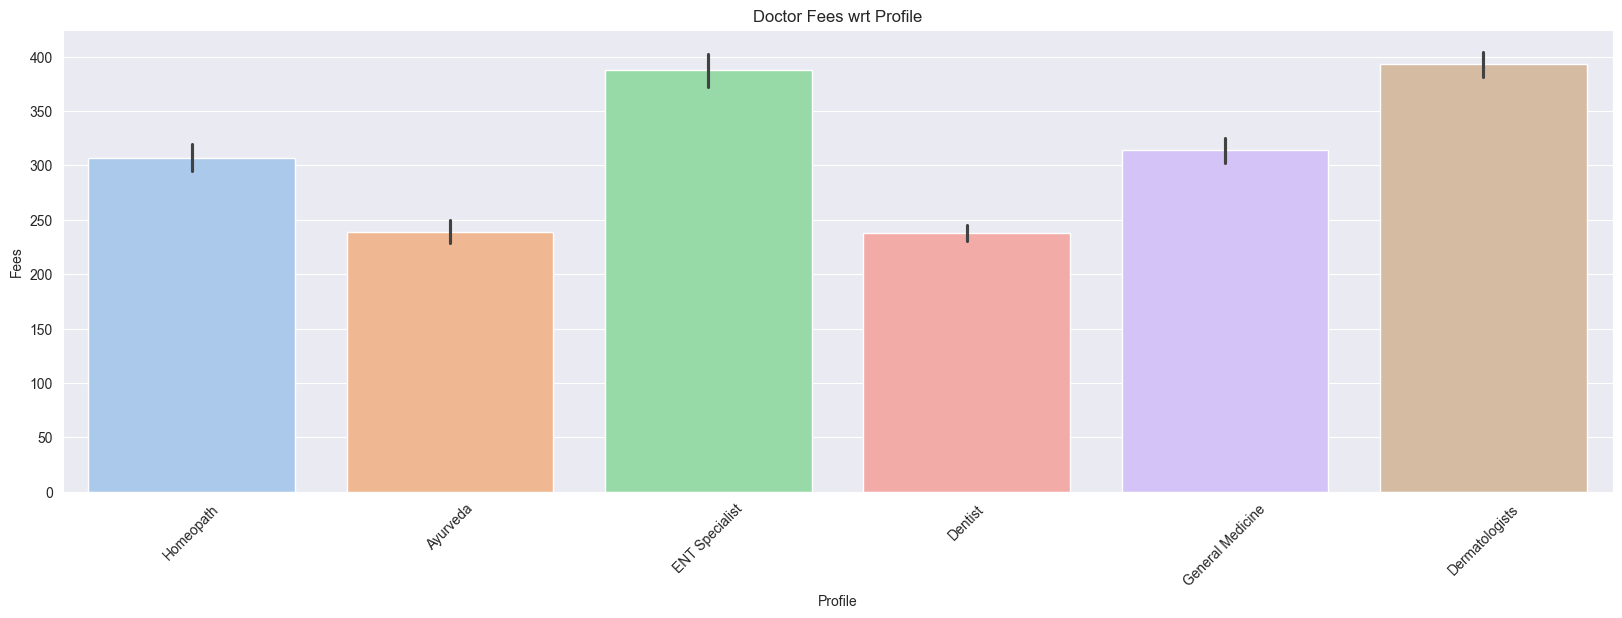

In [20]:
# Bar plot for profile and fee
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(x='Profile', y='Fees', data=train_data, hue='Profile', palette='pastel', legend=False)
plt.title('Doctor Fees wrt Profile')
plt.xticks(rotation=45)
plt.show()
# Dermatologists and ENT Specialist doctors have higher fees compared to other profiles.
# Dentist and Ayurveda doctors have lower fees compared to other profiles.

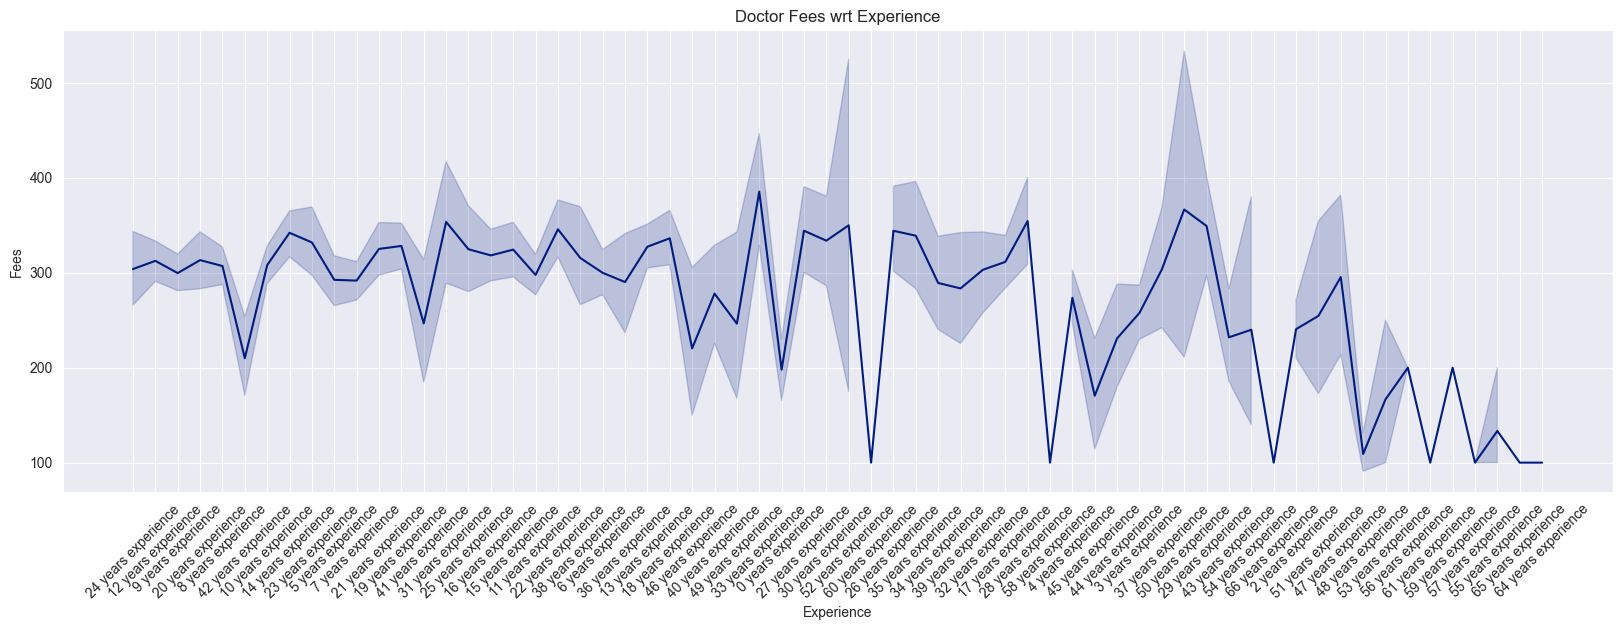

In [21]:
# Line plot for experience and fee
sns.set_style('darkgrid')
sns.set_palette('dark')
plt.figure(figsize=(20, 6))
sns.lineplot(x='Experience', y='Fees', data=train_data)
plt.title('Doctor Fees wrt Experience')
plt.xticks(rotation=45)
plt.show()
# Doctor fees are higher for doctors with more experience till 35.
# Doctor fees are lower for doctors with less experience.
# Fees decrease after 35 years of experience.

Experience Column

In [22]:
train_data['Experience'] = train_data['Experience'].str.split().str[0]
train_data['Experience'] = train_data['Experience'].astype(int)

test_data['Experience'] = test_data['Experience'].str.split().str[0]
test_data['Experience'] = test_data['Experience'].astype(int)

Place Column

In [23]:
train_data['Place'].value_counts()

Place
HSR Layout, Bangalore                75
Andheri West, Mumbai                 70
Dwarka, Delhi                        67
Banjara Hills, Hyderabad             64
Mulund West, Mumbai                  54
                                     ..
Kalapatti, Coimbatore                 1
Nand Nagri, Delhi                     1
Balaramapuram, Thiruvananthapuram     1
Madanpura, Mumbai                     1
HAL, Bangalore                        1
Name: count, Length: 877, dtype: int64

In [24]:
# Convert nan to unknown
train_data['Place'].fillna('unknown,unknown', inplace=True)
test_data['Place'].fillna('unknown,unknown', inplace=True)

# Cleaning up inconsistencies in the 'Place' variable and splitting into 'City' and 'Locality'
train_data['Place'] = train_data['Place'].apply(lambda x: ','.join(str(x).lower().replace(" ", "").split(",")))
test_data['Place'] = test_data['Place'].apply(lambda x: ','.join(str(x).lower().replace(" ", "").split(",")))

train_data['City'] = train_data['Place'].apply(lambda x: str(x).replace(' ', '').split(',')[-1])
train_data['Locality'] = train_data['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])
test_data['City'] = test_data['Place'].apply(lambda x: str(x).replace(' ', '').split(',')[-1])
test_data['Locality'] = test_data['Place'].apply(lambda x: str(x).rsplit(',', 1)[0])

# Handling outlier in 'City'
train_data.loc[train_data['City'] == 'e', ['Place', 'City', 'Locality']] = np.nan

In [25]:
train_data.drop('Place', axis=1, inplace=True)
test_data.drop('Place', axis=1, inplace=True)

In [26]:
train_data['City'].unique()

array(['ernakulam', 'bangalore', 'chennai', 'delhi', 'hyderabad',
       'coimbatore', 'mumbai', 'thiruvananthapuram', 'unknown', nan],
      dtype=object)

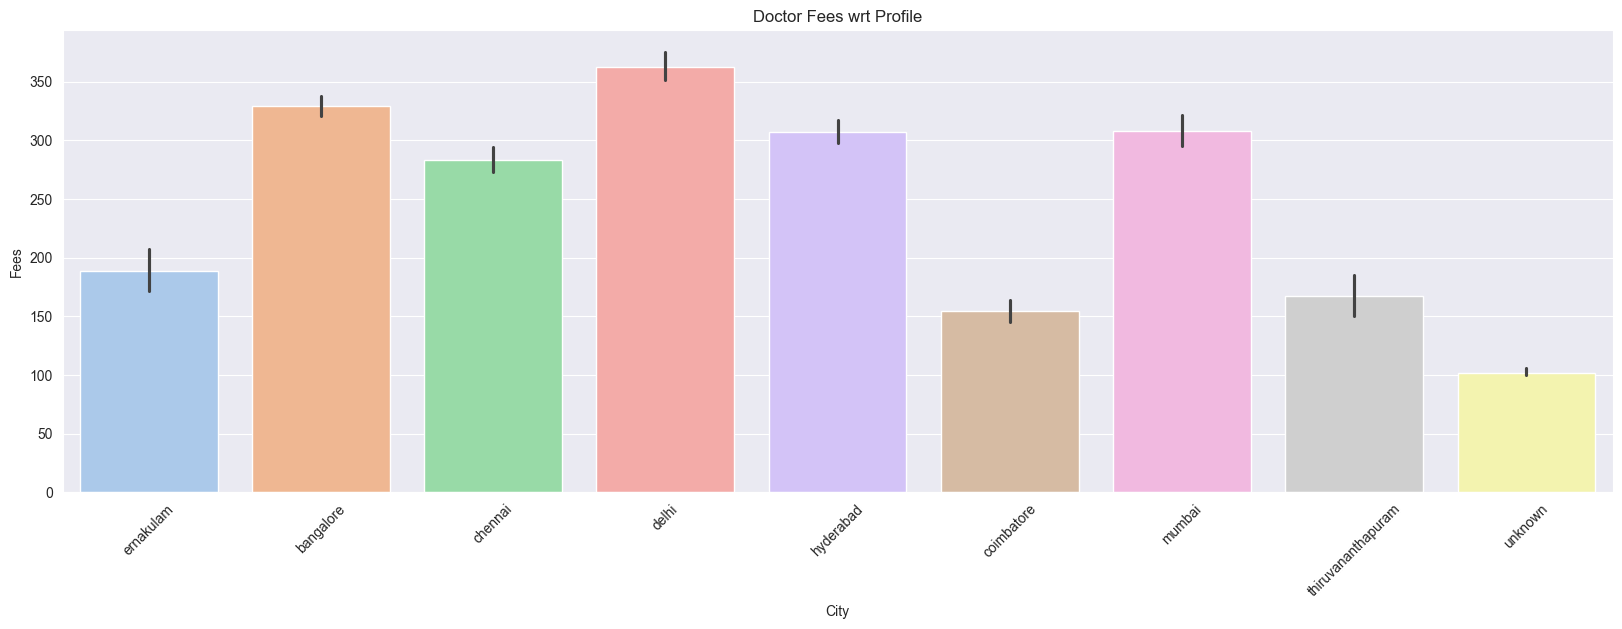

In [27]:
# Bar plot for city and fee
sns.set_style('darkgrid')
plt.figure(figsize=(20, 6))
sns.barplot(x='City', y='Fees', data=train_data, hue='City', palette='pastel', legend=False)
plt.title('Doctor Fees wrt Profile')
plt.xticks(rotation=45)
plt.show()
# Doctor fees in metro cities like Delhi, Bangalore, Mumbai and Hyderabad are higher compared to other cities.
# Doctor fees in cities like Coimbatore, Thiruvananthapuram, Ernakulam and Unknown city are lower compared to other cities.

In [28]:
test_data['City'].unique()

array(['mumbai', 'hyderabad', 'chennai', 'delhi', 'bangalore',
       'coimbatore', 'thiruvananthapuram', 'ernakulam', 'unknown'],
      dtype=object)

In [29]:
train_data['City'].value_counts()

City
bangalore             1258
mumbai                1219
delhi                 1185
hyderabad              951
chennai                855
coimbatore             228
ernakulam              153
thiruvananthapuram      86
unknown                 25
Name: count, dtype: int64

In [30]:
test_data['City'].value_counts()

City
bangalore             420
delhi                 417
mumbai                389
hyderabad             333
chennai               287
coimbatore             70
ernakulam              48
thiruvananthapuram     17
unknown                 6
Name: count, dtype: int64

In [31]:
# Replace Sector 5 with Delhi and nan with unknown
train_data['City'] = np.where(train_data['City'] == 'Sector5', 'Delhi', train_data['City'])
train_data['City'] = np.where(train_data['City'] == 'nan', 'Unknown', train_data['City'])

train_data['City'].value_counts()

City
bangalore             1258
mumbai                1219
delhi                 1185
hyderabad              951
chennai                855
coimbatore             228
ernakulam              153
thiruvananthapuram      86
unknown                 25
Name: count, dtype: int64

In [32]:
# Function to dummify categorical features
def get_dummies(dataframe, feature_name):
    dummy = pd.get_dummies(dataframe[feature_name], prefix=feature_name)
    dummy.drop(dummy.columns[0], axis=1, inplace=True)  # Avoid dummy variable trap
    return pd.concat([dataframe, dummy], axis=1)

In [33]:
# Dummifying the 'City' column
train_data = get_dummies(train_data, 'City')
test_data = get_dummies(test_data, 'City')

In [34]:
train_data.drop('City', axis=1, inplace=True)
train_data.head()

,Qualification,Experience,Rating,Profile,Miscellaneous_Info,Fees,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_thiruvananthapuram,City_unknown
0,"BHMS, MD - Homeopathy",24,100%,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,kakkanad,False,False,False,True,False,False,False,False
1,"BAMS, MD - Ayurveda Medicine",12,98%,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,whitefield,False,False,False,False,False,False,False,False
2,"MBBS, MS - Otorhinolaryngology",9,NaN,ENT Specialist,NaN,300,mathikere-bel,False,False,False,False,False,False,False,False
3,"BSc - Zoology, BAMS",12,NaN,Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,bannerghattaroad,False,False,False,False,False,False,False,False
4,BAMS,20,100%,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,keelkattalai,True,False,False,False,False,False,False,False


Location Column

In [35]:
train_data['Locality'] = train_data['Locality'].astype(str)
test_data['Locality'] = test_data['Locality'].astype(str)

In [36]:
# Function to generate locality frequency data
def generate_locality_stats(df):
    text = ",".join(df['Locality'])
    locality_counts = Counter(text.split(','))
    locality_df = pd.DataFrame.from_dict(locality_counts, orient='index').reset_index()
    locality_df.columns = ['Locality', 'Count']
    return locality_df.sort_values(by='Count', ascending=False).reset_index(drop=True)

In [37]:
# Get the top 10 localities for train and test data
train_locality_stats = generate_locality_stats(train_data)
test_locality_stats = generate_locality_stats(test_data)

print("Top 10 localities in training data:\n", train_locality_stats.head(10))
print("Top 10 localities in test data:\n", test_locality_stats.head(10))

Top 10 localities in training data:
         Locality  Count
0      hsrlayout     75
1    andheriwest     70
2         dwarka     68
3   banjarahills     64
4     mulundwest     54
5   borivaliwest     52
6  kandivaliwest     50
7    indiranagar     48
8      maladwest     47
9    malleswaram     47
Top 10 localities in test data:
            Locality  Count
0       andheriwest     27
1        mulundwest     27
2            dwarka     26
3        whitefield     23
4         hsrlayout     22
5      banjarahills     21
6            rohini     19
7  bannerghattaroad     18
8      shalimarbagh     17
9             adyar     16


In [38]:
# Define a function to encode categorical features
def encode(data):
    return data.astype('category').cat.codes

In [39]:
# Encode the `Locality` feature in the test dataset
test_data['Locality_code'] = encode(test_data['Locality'])

test_data.head()

,Qualification,Experience,Rating,Profile,Miscellaneous_Info,City,Locality,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,City_thiruvananthapuram,City_unknown,Locality_code
0,MBBS,35,NaN,General Medicine,NaN,mumbai,ghatkopareast,False,False,False,False,False,True,False,False,142
1,"MBBS, Diploma in Otorhinolaryngology (DLO)",31,NaN,ENT Specialist,NaN,hyderabad,westmarredpally,False,False,False,False,True,False,False,False,578
2,"MBBS, DDVL",40,70%,Dermatologists,"70% 4 Feedback KK Nagar, Chennai",chennai,kknagar,True,False,False,False,False,False,False,False,258
3,BAMS,0,NaN,Ayurveda,NaN,delhi,newashoknagar,False,False,True,False,False,False,False,False,373
4,"BDS, MDS - Conservative Dentistry & Endodontics",16,100%,Dentist,General Dentistry Conservative Dentistry Cosme...,bangalore,kanakpuraroad,False,False,False,False,False,False,False,False,227


In [40]:
# Merge the encoded localities into the training data
# Create a unique mapping of locality and its encoded value
locality_mapping = test_data[['Locality', 'Locality_code']].drop_duplicates()

# Perform a left join to ensure all training localities are encoded
train_data = train_data.merge(locality_mapping, on='Locality', how='left')

# Verify the merged result
print("Training data after merging encoded `Locality`:\n", train_data.head())

Training data after merging encoded `Locality`:
                     Qualification  Experience Rating         Profile  \
0           BHMS, MD - Homeopathy          24   100%       Homeopath   
1    BAMS, MD - Ayurveda Medicine          12    98%        Ayurveda   
2  MBBS, MS - Otorhinolaryngology           9    NaN  ENT Specialist   
3             BSc - Zoology, BAMS          12    NaN        Ayurveda   
4                            BAMS          20   100%        Ayurveda   

                                  Miscellaneous_Info  Fees          Locality  \
0               100% 16 Feedback Kakkanad, Ernakulam   100          kakkanad   
1              98% 76 Feedback Whitefield, Bangalore   350        whitefield   
2                                                NaN   300     mathikere-bel   
3  Bannerghatta Road, Bangalore ₹250 Available on...   250  bannerghattaroad   
4              100% 4 Feedback Keelkattalai, Chennai   250      keelkattalai   

   City_chennai  City_coimbatore  Cit

In [41]:
train_data.drop('Locality', axis=1, inplace=True)
test_data.drop('Locality', axis=1, inplace=True)

Qualification Column

In [42]:
# Checking the maximum and minimum values of the qualification in test and train data
qual_train =train_data['Qualification'].apply(lambda x: len(x.split(',')))
qual_test = test_data['Qualification'].apply(lambda x: len(x.split(',')))

print("Maximum qualifications in train data is: ",max(qual_train),"and the data is: ",train_data['Qualification'][qual_train.idxmax()])
print("Maximum qualifications in test data is: ",max(qual_test),"and the data is: ",test_data['Qualification'][qual_test.idxmax()])
print("Minimum qualifications in train data is: ",min(qual_train),"and the data is: ",train_data['Qualification'][qual_train.idxmin()])
print("Minimum qualifications in test data is: ",min(qual_test),"and the data is: ",test_data['Qualification'][qual_test.idxmin()])

Maximum qualifications in train data is:  10 and the data is:  Fellowship in Oral implantlogy, Certified Advance Course In Endodontics, Certified in Orthodontics, Certification in Full Mouth Rehabilitation, Certified BPS Dentist, Certificate in Cosmetic Dentistry, Professional Implantology Training Course (PITC), Fellowship in Advanced Endoscopic Sinus Surgery, Degree in Dental Implant, Fellowship in Lasers & Cosmetology
Maximum qualifications in test data is:  17 and the data is:  BDS, PG Diploma in Conservative, Endodontics and Aesthetic Dentistry, Fellowship In Clinical Cosmetology, PG Diploma In Clinical Cosmetology (PGDCC), MBA - Hospital Management, Diploma in Cosmetic Dentistry, Fellow of Academy of General Education (FAGE), Advanced Retreatment Course in RCT, Advanced Endotontic Course On Root Canal, Certified Course in Oral Surgery, MIDA, Certification in Prosthodontics & Periodontology, Certified Advanced Course in Wisdom Tooth Extraction, Certificate in Cosmetic Dentistry, F

In [43]:
def clean_qualifications(text):
    # Replace commas inside parentheses with hyphen
    # This avoids issues with commas being inside qualifications like "MD-General Medicine"
    text = re.sub(r'\([^()]+\)', lambda x: x.group().replace(",", "-"), text)
    
    # Convert qualifications to lowercase for uniformity
    # Remove spaces within qualifications
    text = text.lower().replace(" ", "")
    
    # Split the qualifications by comma, then sort them alphabetically
    return ','.join(sorted(text.split(',')))

In [44]:
# Apply the cleaning function to both train_data and test_data datasets
train_data['Qualification'] = train_data['Qualification'].apply(lambda x: clean_qualifications(x))
test_data['Qualification'] = test_data['Qualification'].apply(lambda x: clean_qualifications(x))

In [45]:
# Function to create a single document of all qualifications separated by commas
def create_qualification_document(series):
    text = ''
    for qualification in series:
        text += qualification + ','  # Concatenate qualifications
    return text

In [46]:
# Count unique qualifications in the train dataset and show the top 10
train_qualifications_doc = create_qualification_document(train_data['Qualification'])
train_qual_counts = pd.DataFrame.from_dict(dict(Counter(train_qualifications_doc.split(',')).most_common()), orient='index').reset_index()
train_qual_counts.columns = ['Qualification', 'Count']
print("Top 10 Qualifications in Train Dataset:")
print(train_qual_counts.head(10))

Top 10 Qualifications in Train Dataset:
                       Qualification  Count
0                               mbbs   2808
1                                bds   1363
2                               bams    764
3                               bhms    749
4                     md-dermatology    606
5                             ms-ent    411
6                venereology&leprosy    297
7                 md-generalmedicine    285
8  diplomainotorhinolaryngology(dlo)    250
9                      md-homeopathy    181


In [47]:
# Count unique qualifications in the test dataset and show the top 10
test_qualifications_doc = create_qualification_document(test_data['Qualification'])
test_qual_counts = pd.DataFrame.from_dict(dict(Counter(test_qualifications_doc.split(',')).most_common()), orient='index').reset_index()
test_qual_counts.columns = ['Qualification', 'Count']
print("\nTop 10 Qualifications in Test Dataset:")
print(test_qual_counts.head(10))


Top 10 Qualifications in Test Dataset:
                       Qualification  Count
0                               mbbs    980
1                                bds    428
2                               bhms    249
3                               bams    243
4                     md-dermatology    196
5                             ms-ent    128
6                 md-generalmedicine     99
7                venereology&leprosy     91
8  diplomainotorhinolaryngology(dlo)     85
9                               ddvl     67


In [48]:
# Create a mapping of qualifications to numeric codes for the test data
# This ensures that we only encode qualifications that appear in the test set
qualification_to_code = {qual: code for code, qual in enumerate(test_qual_counts['Qualification'])}
print("\nQualification to Code Mapping (Test Set):")
print(qualification_to_code)


Qualification to Code Mapping (Test Set):
{'mbbs': 0, 'bds': 1, 'bhms': 2, 'bams': 3, 'md-dermatology': 4, 'ms-ent': 5, 'md-generalmedicine': 6, 'venereology&leprosy': 7, 'diplomainotorhinolaryngology(dlo)': 8, 'ddvl': 9, 'md-homeopathy': 10, 'ms-otorhinolaryngology': 11, 'md-ayurvedamedicine': 12, 'dnb-ent': 13, 'ddv': 14, 'mds-conservativedentistry&endodontics': 15, 'md-medicine': 16, 'mds-oral&maxillofacialsurgery': 17, 'dnb-generalmedicine': 18, 'dnb-dermatology&venereology': 19, 'postgraduatediplomaindiabetology(pgdd)': 20, 'md-internalmedicine': 21, 'mds-orthodontics': 22, 'mds': 23, 'mds-prosthodontistandcrownbridge': 24, 'dnb': 25, 'diplomaindermatology': 26, 'mds-periodontologyandoralimplantology': 27, 'mds-paedodonticsandpreventivedentistry': 28, 'mds-prosthodontics': 29, 'dnb-otorhinolaryngology': 30, 'ms-generalsurgery': 31, 'dhms(diplomainhomeopathicmedicineandsurgery)': 32, 'mds-orthodonticsanddentofacialorthopaedics': 33, 'fellowofacademyofgeneraleducation(fage)': 34, '

In [49]:
# Function to extract a specific qualification column from a list of qualifications
def get_qualification_column(dataframe, column, index):
    return dataframe[column].str.split(',').str[index]

In [50]:
# Split the qualifications into separate columns for both datasets
# For the train dataset, we assume a maximum of 10 qualifications per individual (can adjust this based on your data)
for i in range(0, 10):
    qual_column = f"Qual_{i+1}"
    train_data[qual_column] = get_qualification_column(train_data, 'Qualification', i)

# For the test dataset, similarly split the qualifications into separate columns
for i in range(0, 10):
    qual_column = f"Qual_{i+1}"
    test_data[qual_column] = get_qualification_column(test_data, 'Qualification', i)

In [51]:
# Encoding categorical qualifications for both train and test datasets
# We will only encode the test dataset to prevent mismatch in the unseen qualifications
# that might exist in the train data but not the test data
for i in range(1, 11):
    qual_column = f"Qual_{i}"
    # Replace qualifications with their corresponding encoded values in the test set
    test_data[qual_column] = test_data[qual_column].map(qualification_to_code).fillna(0)  # Use -1 for missing qualifications
    # Replace qualifications with their corresponding encoded values in the train set
    train_data[qual_column] = train_data[qual_column].map(qualification_to_code).fillna(0)  # Use -1 for missing qualifications

In [52]:
# Display the first few rows of the modified train and test datasets
print("\nTrain Data (After Processing Qualifications):")
print(train_data.head())


Train Data (After Processing Qualifications):
                 Qualification  Experience Rating         Profile  \
0           bhms,md-homeopathy          24   100%       Homeopath   
1     bams,md-ayurvedamedicine          12    98%        Ayurveda   
2  mbbs,ms-otorhinolaryngology           9    NaN  ENT Specialist   
3             bams,bsc-zoology          12    NaN        Ayurveda   
4                         bams          20   100%        Ayurveda   

                                  Miscellaneous_Info  Fees  City_chennai  \
0               100% 16 Feedback Kakkanad, Ernakulam   100         False   
1              98% 76 Feedback Whitefield, Bangalore   350         False   
2                                                NaN   300         False   
3  Bannerghatta Road, Bangalore ₹250 Available on...   250         False   
4              100% 4 Feedback Keelkattalai, Chennai   250          True   

   City_coimbatore  City_delhi  City_ernakulam  ...  Qual_1  Qual_2  Qual_3  \
0 

In [53]:
print("\nTest Data (After Processing Qualifications):")
print(test_data.head())


Test Data (After Processing Qualifications):
                               Qualification  Experience Rating  \
0                                       mbbs          35    NaN   
1     diplomainotorhinolaryngology(dlo),mbbs          31    NaN   
2                                  ddvl,mbbs          40    70%   
3                                       bams           0    NaN   
4  bds,mds-conservativedentistry&endodontics          16   100%   

            Profile                                 Miscellaneous_Info  \
0  General Medicine                                                NaN   
1    ENT Specialist                                                NaN   
2    Dermatologists                   70% 4 Feedback KK Nagar, Chennai   
3          Ayurveda                                                NaN   
4           Dentist  General Dentistry Conservative Dentistry Cosme...   

        City  City_chennai  City_coimbatore  City_delhi  City_ernakulam  ...  \
0     mumbai         False

In [54]:
# Adding the number of qualifications as a new column
train_data['Qual_count'] = train_data['Qualification'].apply(lambda x: len(x.split(',')))
test_data['Qual_count'] = test_data['Qualification'].apply(lambda x: len(x.split(',')))

In [55]:
train_data.drop('Qualification', axis=1, inplace=True)
test_data.drop('Qualification', axis=1, inplace=True)

Ratings Column

In [56]:
# Filling missing ratings with 0% and converting to integers
train_data['Rating'].fillna('0%', inplace=True)
train_data['Rating'] = train_data['Rating'].str.slice(stop=-1).astype(int)
test_data['Rating'].fillna('0%', inplace=True)
test_data['Rating'] = test_data['Rating'].str.slice(stop=-1).astype(int)

In [57]:
train_data.head()

,Experience,Rating,Profile,Miscellaneous_Info,Fees,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,...,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count
0,24,100,Homeopath,"100% 16 Feedback Kakkanad, Ernakulam",100,False,False,False,True,False,...,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
1,12,98,Ayurveda,"98% 76 Feedback Whitefield, Bangalore",350,False,False,False,False,False,...,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,9,0,ENT Specialist,NaN,300,False,False,False,False,False,...,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,12,0,Ayurveda,"Bannerghatta Road, Bangalore ₹250 Available on...",250,False,False,False,False,False,...,309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,20,100,Ayurveda,"100% 4 Feedback Keelkattalai, Chennai",250,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1


In [58]:
test_data.head()

,Experience,Rating,Profile,Miscellaneous_Info,City,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,...,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,Qual_10,Qual_count
0,35,0,General Medicine,NaN,mumbai,False,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,31,0,ENT Specialist,NaN,hyderabad,False,False,False,False,True,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
2,40,70,Dermatologists,"70% 4 Feedback KK Nagar, Chennai",chennai,True,False,False,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,0,0,Ayurveda,NaN,delhi,False,False,True,False,False,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,16,100,Dentist,General Dentistry Conservative Dentistry Cosme...,bangalore,False,False,False,False,False,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Profile Column

In [59]:
# Check unique profiles in the dataset
print("Unique Profile counts in training data:\n", train_data['Profile'].value_counts())

Unique Profile counts in training data:
 Profile
Dentist             1397
General Medicine    1173
Dermatologists      1034
Homeopath            843
Ayurveda             786
ENT Specialist       728
Name: count, dtype: int64


In [60]:
# Normalize and dummify the `Profile` column
train_data['Profile'] = train_data['Profile'].apply(lambda x: str(x).lower().replace(" ", ""))
test_data['Profile'] = test_data['Profile'].apply(lambda x: str(x).lower().replace(" ", ""))

In [61]:
# Function to create dummy variables for a column
def get_dummies(df, column):
    return pd.concat([df, pd.get_dummies(df[column], prefix=column)], axis=1).drop(column, axis=1)

In [62]:
# Apply dummification
train_data = get_dummies(train_data, 'Profile')
test_data = get_dummies(test_data, 'Profile')

In [63]:
train_data.head()

,Experience,Rating,Miscellaneous_Info,Fees,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,...,Qual_8,Qual_9,Qual_10,Qual_count,Profile_ayurveda,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath
0,24,100,"100% 16 Feedback Kakkanad, Ernakulam",100,False,False,False,True,False,False,...,0.0,0.0,0.0,2,False,False,False,False,False,True
1,12,98,"98% 76 Feedback Whitefield, Bangalore",350,False,False,False,False,False,False,...,0.0,0.0,0.0,2,True,False,False,False,False,False
2,9,0,NaN,300,False,False,False,False,False,False,...,0.0,0.0,0.0,2,False,False,False,True,False,False
3,12,0,"Bannerghatta Road, Bangalore ₹250 Available on...",250,False,False,False,False,False,False,...,0.0,0.0,0.0,2,True,False,False,False,False,False
4,20,100,"100% 4 Feedback Keelkattalai, Chennai",250,True,False,False,False,False,False,...,0.0,0.0,0.0,1,True,False,False,False,False,False


In [64]:
test_data.head()

,Experience,Rating,Miscellaneous_Info,City,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,...,Qual_8,Qual_9,Qual_10,Qual_count,Profile_ayurveda,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath
0,35,0,NaN,mumbai,False,False,False,False,False,True,...,0.0,0.0,0.0,1,False,False,False,False,True,False
1,31,0,NaN,hyderabad,False,False,False,False,True,False,...,0.0,0.0,0.0,2,False,False,False,True,False,False
2,40,70,"70% 4 Feedback KK Nagar, Chennai",chennai,True,False,False,False,False,False,...,0.0,0.0,0.0,2,False,False,True,False,False,False
3,0,0,NaN,delhi,False,False,True,False,False,False,...,0.0,0.0,0.0,1,True,False,False,False,False,False
4,16,100,General Dentistry Conservative Dentistry Cosme...,bangalore,False,False,False,False,False,False,...,0.0,0.0,0.0,2,False,True,False,False,False,False


Miscellaneous Info

In [65]:
# Assuming train_data and test_data are your DataFrame variables
# Replace commas in 'Miscellaneous_Info'
train_data['Miscellaneous_Info'] = train_data['Miscellaneous_Info'].str.replace(",", "", regex=False)
test_data['Miscellaneous_Info'] = test_data['Miscellaneous_Info'].str.replace(",", "", regex=False)

# Replace the Indian Rupee symbol with 'INR'
rupee_sign = unicodedata.lookup('Indian Rupee Sign')
train_data['Miscellaneous_Info'] = train_data['Miscellaneous_Info'].str.replace(rupee_sign, 'INR ', regex=False)
test_data['Miscellaneous_Info'] = test_data['Miscellaneous_Info'].str.replace(rupee_sign, 'INR ', regex=False)


In [66]:
# Function to extract fees
def find_fees(data):
    if not isinstance(data, str):
        return 0
    result = re.search(r'INR (\d+)', data)
    return int(result.group(1)) if result else 0

# Extract fees for train and test datasets
train_data['Fees'] = train_data['Miscellaneous_Info'].apply(find_fees)
test_data['Fees'] = test_data['Miscellaneous_Info'].apply(find_fees)

In [67]:
# Function to extract feedback numbers
def find_feedback(data):
    if not isinstance(data, str):
        return 0
    result = re.search(r' (\d+) Feedback', data)
    return int(result.group(1)) if result else 0

# Extract feedback numbers for train and test datasets
train_data['feedback_num'] = train_data['Miscellaneous_Info'].apply(find_feedback)
test_data['feedback_num'] = test_data['Miscellaneous_Info'].apply(find_feedback)

In [68]:
# Display processed data for validation
print(train_data[['Miscellaneous_Info', 'feedback_num', 'Fees']].head())
print(test_data[['Miscellaneous_Info', 'feedback_num', 'Fees']].head())

                                  Miscellaneous_Info  feedback_num  Fees
0                100% 16 Feedback Kakkanad Ernakulam            16     0
1               98% 76 Feedback Whitefield Bangalore            76     0
2                                                NaN             0     0
3  Bannerghatta Road Bangalore INR 250 Available ...             0   250
4               100% 4 Feedback Keelkattalai Chennai             4     0
                                  Miscellaneous_Info  feedback_num  Fees
0                                                NaN             0     0
1                                                NaN             0     0
2                    70% 4 Feedback KK Nagar Chennai             4     0
3                                                NaN             0     0
4  General Dentistry Conservative Dentistry Cosme...             0     0


In [69]:
# Analyze Fees Distribution in train dataset
fees_distribution = (
    train_data['Fees']
    .value_counts()
    .reset_index()
)

# Rename the columns for clarity
fees_distribution.columns = ['Fee Value', 'Frequency']

# Display the result
print(fees_distribution)


    Fee Value  Frequency
0           0       5768
1         200         33
2         500         27
3         250         24
4         300         23
5         600         15
6         100         14
7        1000         13
8         800         10
9         400          7
10       1200          6
11        700          5
12        350          4
13       1500          3
14       1750          2
15       1350          1
16        475          1
17        150          1
18        450          1
19        750          1
20       2000          1
21       2500          1


In [70]:
# Check records in the train dataset where Fees are less than 50
low_fees_records = train_data[train_data['Fees'] < 50]
print("Records with Fees < 50:")
low_fees_records

Records with Fees < 50:


,Experience,Rating,Miscellaneous_Info,Fees,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,...,Qual_9,Qual_10,Qual_count,Profile_ayurveda,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,feedback_num
0,24,100,100% 16 Feedback Kakkanad Ernakulam,0,False,False,False,True,False,False,...,0.0,0.0,2,False,False,False,False,False,True,16
1,12,98,98% 76 Feedback Whitefield Bangalore,0,False,False,False,False,False,False,...,0.0,0.0,2,True,False,False,False,False,False,76
2,9,0,NaN,0,False,False,False,False,False,False,...,0.0,0.0,2,False,False,False,True,False,False,0
4,20,100,100% 4 Feedback Keelkattalai Chennai,0,True,False,False,False,False,False,...,0.0,0.0,1,True,False,False,False,False,False,4
5,8,0,NaN,0,True,False,False,False,False,False,...,0.0,0.0,1,True,False,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5956,19,98,98% 45 Feedback Basavanagudi Bangalore,0,False,False,False,False,False,False,...,0.0,0.0,2,False,False,False,True,False,False,45
5957,33,0,NaN,0,True,False,False,False,False,False,...,0.0,0.0,1,False,False,False,False,True,False,0
5958,41,97,97% 11 Feedback Greater Kailash Part 2 Delhi,0,False,False,True,False,False,False,...,0.0,0.0,1,False,False,False,False,True,False,11
5959,15,90,General Medical Consultation Viral Fever Treat...,0,False,False,False,False,False,True,...,0.0,0.0,2,False,False,False,False,True,False,0


In [71]:
# Describe years of experience in the training set
train_data['Experience'].describe()

count    5961.000000
mean       17.303976
std        11.142798
min         0.000000
25%         9.000000
50%        14.000000
75%        23.000000
max        66.000000
Name: Experience, dtype: float64

In [72]:
# Describe years of experience in the test set
test_data['Experience'].describe()

count    1987.000000
mean       17.874685
std        11.366764
min         0.000000
25%         9.000000
50%        15.000000
75%        24.000000
max        65.000000
Name: Experience, dtype: float64

In [73]:
# Check records in the train dataset where Experience is 0
zero_exp_records = train_data[train_data['Experience'] == 0]
print("Records with Experience = 0:")
zero_exp_records

Records with Experience = 0:


,Experience,Rating,Miscellaneous_Info,Fees,City_chennai,City_coimbatore,City_delhi,City_ernakulam,City_hyderabad,City_mumbai,...,Qual_9,Qual_10,Qual_count,Profile_ayurveda,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,feedback_num
91,0,0,NaN,0,False,False,False,False,False,False,...,0.0,0.0,1,False,False,True,False,False,False,0
168,0,0,NaN,0,False,False,False,False,False,True,...,0.0,0.0,1,True,False,False,False,False,False,0
380,0,0,NaN,0,False,False,False,False,False,True,...,0.0,0.0,3,False,False,False,True,False,False,0
383,0,0,Dental Fillings Dental Crowns General Dentistry,0,True,False,False,False,False,False,...,0.0,0.0,1,False,True,False,False,False,False,0
409,0,0,NaN,0,False,True,False,False,False,False,...,0.0,0.0,1,False,True,False,False,False,False,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5533,0,0,Skin Allergy Treatment Chronic Skin Allergy Wr...,0,False,False,False,False,False,False,...,0.0,0.0,1,False,False,False,False,False,True,0
5551,0,0,NaN,0,False,False,False,False,False,False,...,0.0,0.0,1,False,False,True,False,False,False,0
5723,0,0,NaN,0,False,False,False,False,False,False,...,0.0,0.0,1,False,False,True,False,False,False,0
5821,0,0,NaN,0,False,False,True,False,False,False,...,0.0,0.0,2,False,False,False,False,True,False,0


In [74]:
# Define features for model training and prediction
cols_to_use = [
    'Rating', 'Qual_1', 'Qual_2', 'Qual_3', 'Qual_4', 'Qual_5', 'Qual_6', 
    'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_count', 'Experience', 
    'City_chennai', 'City_coimbatore', 'City_delhi', 'City_ernakulam', 'City_hyderabad',
    'City_mumbai', 'City_unknown', 'City_thiruvananthapuram', 'Profile_dentist', 'Profile_dermatologists', 
    'Profile_entspecialist', 'Profile_generalmedicine', 'Profile_homeopath', 'Locality_code', 'feedback_num', 
    'Fees', 'Miscellaneous_Info'
]

In [75]:
# Target column
target_col = 'fees_val'

In [76]:
train_data = train_data[cols_to_use].copy()

In [77]:
# Check for missing values in each column for both datasets
print("Missing values in train_data:")
print(train_data.isnull().sum())
print("\nMissing values in test_data:")
print(test_data.isnull().sum())

Missing values in train_data:
Rating                        0
Qual_1                        0
Qual_2                        0
Qual_3                        0
Qual_4                        0
Qual_5                        0
Qual_6                        0
Qual_7                        0
Qual_8                        0
Qual_9                        0
Qual_10                       0
Qual_count                    0
Experience                    0
City_chennai                  0
City_coimbatore               0
City_delhi                    0
City_ernakulam                0
City_hyderabad                0
City_mumbai                   0
City_unknown                  0
City_thiruvananthapuram       0
Profile_dentist               0
Profile_dermatologists        0
Profile_entspecialist         0
Profile_generalmedicine       0
Profile_homeopath             0
Locality_code               727
feedback_num                  0
Fees                          0
Miscellaneous_Info         2620
dtype: int

In [78]:
# Check unique values for 'fees_val' in train data
print("\nUnique 'fees_val' distribution in train data:")
print(train_data['Fees'].value_counts())


Unique 'fees_val' distribution in train data:
Fees
0       5768
200       33
500       27
250       24
300       23
600       15
100       14
1000      13
800       10
400        7
1200       6
700        5
350        4
1500       3
1750       2
1350       1
475        1
150        1
450        1
750        1
2000       1
2500       1
Name: count, dtype: int64


In [79]:
# Check if any fees_val greater than 999 exist in both train and test datasets
print("\nChecking 'Fees' > 999 in train data:")
print(train_data[train_data['Fees'] > 999][['Miscellaneous_Info', 'Fees']])


Checking 'Fees' > 999 in train data:
                                     Miscellaneous_Info  Fees
672               Mahim Mumbai INR 1200 Available Today  1200
770                    4 Feedback Mahim Mumbai INR 1200  1200
996           Andheri East Mumbai INR 1000 Visits Today  1000
1038          Prabhadevi Mumbai INR 1000 Visits On-Call  1000
1039            Saket Delhi INR 1350 Available Tomorrow  1350
1077                 1 Feedback Chembur Mumbai INR 1200  1200
1141                   3 Feedback Parel Mumbai INR 1750  1750
1601  Vileparle West Mumbai INR 1200INR 150020% OFF*...  1200
1683       Andheri West Mumbai INR 1200 Available Today  1200
2007            1 Feedback Shalimar Bagh Delhi INR 1000  1000
2645                    3 Feedback Saket Delhi INR 1200  1200
2668            Prabhadevi Mumbai INR 1000 Visits Today  1000
3053       Andheri West Mumbai INR 1500 Available Today  1500
3159       Andheri West Mumbai INR 1500 Available Today  1500
3278              Borivali Mumba

In [80]:
print("\nChecking 'Fees' > 999 in test data:")
print(test_data[test_data['Fees'] > 999][['Miscellaneous_Info']])


Checking 'Fees' > 999 in test data:
                                     Miscellaneous_Info
43            Patparganj Delhi INR 1000 Available Today
103                Saket Delhi INR 1500 Available Today
193    3 Feedback Greater Kailash Part 2 Delhi INR 3500
206           Prabhadevi Mumbai INR 1500 Visits On-Call
443   Panchsheel Park Delhi INR 1200 Available Tomorrow
493                  Mahim Mumbai INR 1000 Visits Today
494             3 Feedback Andheri West Mumbai INR 1200
636         Pusa Road Delhi INR 1200 Available Tomorrow
661   Panchsheel Park Delhi INR 1000 Available Tomorrow
662          Prabhadevi Mumbai INR 1500 Visits Tomorrow
754       Mahim Mumbai INR 1200 Available on Mon 11 Feb
821             1 Feedback Shalimar Bagh Delhi INR 1500
949             1 Feedback Andheri West Mumbai INR 1000
1023       Andheri West Mumbai INR 1500 Available Today
1031         Prabhadevi Mumbai INR 1500 Visits Tomorrow
1499            Saket Delhi INR 1000 Available Tomorrow
1562       

In [81]:
# Mark Fees as 100 where required in the train_data
train_data['Fees'] = np.where(train_data['Miscellaneous_Info'].str.contains('getinspiredbyremarkablestoriesofpeoplelikeyou', na=False), 100, train_data['Fees'])

In [82]:
train_data.head()

,Rating,Qual_1,Qual_2,Qual_3,Qual_4,Qual_5,Qual_6,Qual_7,Qual_8,Qual_9,...,City_thiruvananthapuram,Profile_dentist,Profile_dermatologists,Profile_entspecialist,Profile_generalmedicine,Profile_homeopath,Locality_code,feedback_num,Fees,Miscellaneous_Info
0,100,2.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,True,217.0,16,0,100% 16 Feedback Kakkanad Ernakulam
1,98,3.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,580.0,76,0,98% 76 Feedback Whitefield Bangalore
2,0,0.0,11.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,True,False,False,320.0,0,0,NaN
3,0,3.0,309.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,52.0,0,250,Bannerghatta Road Bangalore INR 250 Available ...
4,100,3.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,False,False,False,False,False,False,245.0,4,0,100% 4 Feedback Keelkattalai Chennai


In [83]:
test_data = test_data[cols_to_use]

In [84]:
print("\nConsistency check for train_data and test_data:")
print("Train data columns:", train_data.columns)
print("Test data columns:", test_data.columns)


Consistency check for train_data and test_data:
Train data columns: Index(['Rating', 'Qual_1', 'Qual_2', 'Qual_3', 'Qual_4', 'Qual_5', 'Qual_6',
       'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_count', 'Experience',
       'City_chennai', 'City_coimbatore', 'City_delhi', 'City_ernakulam',
       'City_hyderabad', 'City_mumbai', 'City_unknown',
       'City_thiruvananthapuram', 'Profile_dentist', 'Profile_dermatologists',
       'Profile_entspecialist', 'Profile_generalmedicine', 'Profile_homeopath',
       'Locality_code', 'feedback_num', 'Fees', 'Miscellaneous_Info'],
      dtype='object')
Test data columns: Index(['Rating', 'Qual_1', 'Qual_2', 'Qual_3', 'Qual_4', 'Qual_5', 'Qual_6',
       'Qual_7', 'Qual_8', 'Qual_9', 'Qual_10', 'Qual_count', 'Experience',
       'City_chennai', 'City_coimbatore', 'City_delhi', 'City_ernakulam',
       'City_hyderabad', 'City_mumbai', 'City_unknown',
       'City_thiruvananthapuram', 'Profile_dentist', 'Profile_dermatologists',
       'Profile

In [85]:
train_data.drop('Miscellaneous_Info', axis=1, inplace=True)
test_data.drop('Miscellaneous_Info', axis=1, inplace=True)

In [86]:
# Function to check and return missing values statistics
def missing_values_table(df):
    """
    This function takes a dataframe and returns a table showing the 
    number of missing values and the percentage of missing values in each column.
    """
    # Calculate total and percentage of missing values
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * mis_val / len(df)
    
    # Combine the results into a single table
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
        columns={0: 'Missing Values', 1: '% of Total Values'}
    )
    
    # Sort the table by percentage of missing values in descending order
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns['% of Total Values'] != 0
    ].sort_values('% of Total Values', ascending=False).round(1)
    
    # Print summary information
    print(f"Your selected dataframe has {df.shape[1]} columns.")
    print(f"There are {mis_val_table_ren_columns.shape[0]} columns with missing values.")
    
    # Return the table with missing value information
    return mis_val_table_ren_columns

In [87]:
missing_values_table(train_data)

Your selected dataframe has 29 columns.
There are 1 columns with missing values.


,Missing Values,% of Total Values
Locality_code,727,12.2


In [88]:
train_data['Locality_code'].fillna(-1, inplace=True)
test_data['Locality_code'].fillna(-1, inplace=True)

In [89]:
# Define features and target variables
X_train = train_data.copy()
X_test = test_data.copy()
y_train = train_data['Fees'].copy()

In [90]:
# Print shapes of the datasets
print(f"Training features shape: {X_train.shape}")
print(f"Training target shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")

Training features shape: (5961, 29)
Training target shape: (5961,)
Test features shape: (1987, 29)


Model Training

In [91]:
# Model Building
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_val_score

In [92]:
knn = KNeighborsRegressor()
svr = SVR()
rf = RandomForestRegressor()

In [103]:
def model_evaluation(model, X_train, y_train):
    """
    This function evaluates a model using cross-validation and returns the mean RMSE score.
    """
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    # Perform cross-validation
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
    return rmse, scores

In [104]:
# Evaluate the models
models = [knn, svr, rf]
model_names = ['K-Nearest Neighbors', 'Support Vector Machine', 'Random Forest']

for model, name in zip(models, model_names):
    rmse, scores = model_evaluation(model, X_train, y_train)
    print(f"{name} RMSE: {rmse} and Cross-Validation RMSE: {np.mean(np.sqrt(-scores))}")

K-Nearest Neighbors RMSE: 10.105134304178527 and Cross-Validation RMSE: 13.578553822203116
Support Vector Machine RMSE: 105.5169247657743 and Cross-Validation RMSE: 105.8134640233056
Random Forest RMSE: 4.5711364148095806 and Cross-Validation RMSE: 8.227876688717426


In [ ]:
## Best Model = Random Forest Regressor

In [105]:
# grid search cv for Random Forest Regressor
from sklearn.model_selection import GridSearchCV

# Define the parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2],
    'bootstrap': [True, False]
}

# Create the GridSearchCV object
rf_model = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf_model, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)

# Perform the grid search
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("Best parameters found: ", best_params)

# Get the best model
best_rf_model = grid_search.best_estimator_

# Evaluate the best model
rmse, scores = model_evaluation(best_rf_model, X_train, y_train)
print(f"Best Random Forest RMSE: {rmse} and Cross-Validation RMSE: {np.mean(np.sqrt(-scores))}")

Fitting 5 folds for each of 1800 candidates, totalling 9000 fits
Best parameters found:  {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}
Best Random Forest RMSE: 0.6841580456363279 and Cross-Validation RMSE: 8.580819361803803


In [ ]:
# best_rf_model : 0.6841580456363279
# {'bootstrap': False, 'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 50}

In [108]:
# Model training and prediction using K-Fold technique
n_fold = 5
folds = KFold(n_splits=n_fold, shuffle=True, random_state=4)

In [109]:
lgb = lgb.LGBMRegressor()
xgb = xgb.XGBRegressor()
cat = CatBoostRegressor()

In [124]:
# Evaluate the models
models = [lgb, xgb, cat]
model_names = ['LightGBM', 'XGBoost', 'CatBoost']

def model_evaluation(model, X_train, y_train):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_train)
    rmse = np.sqrt(mean_squared_error(y_train, y_pred))
    return rmse

for model, name in zip(models, model_names):
    rmse = model_evaluation(model, X_train, y_train)
    print(f"{name} RMSE: {rmse}")

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000178 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 5961, number of used features: 24
[LightGBM] [Info] Start training from score 15.932729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
LightGBM RMSE: 21.784150496234396
XGBoost RMSE: 0.0009811837894293679
Learning rate set to 0.054285
0:	learn: 106.5600048	total: 80.1ms	remaining: 1m 20s
1:	learn: 101.6655580	total: 81.9ms	remaining: 40.9s
2:	learn: 97.1442779	total: 83.6ms	remaining: 27.8s
3:	learn: 93.0912297	total: 85.1ms	r

In [131]:
# Hyperparameter tuning for LightGBM, XGBoost and CatBoost

# Hyperparameter grid for LightGBM
lgb_param_grid = {
    'num_leaves': [31, 50],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

# Hyperparameter grid for XGBoost
xgb_param_grid = {
    'max_depth': [6, 7],
    'learning_rate': [0.1, 0.05],
    'n_estimators': [100, 200]
}

# Hyperparameter grid for CatBoost
cat_param_grid = {
    'iterations': [500, 1000],
    'learning_rate': [0.1, 0.05]
}

In [132]:
# Create the GridSearchCV objects
lgb_grid_search = GridSearchCV(estimator=lgb, param_grid=lgb_param_grid, cv=folds, n_jobs=-1, verbose=2)
xgb_grid_search = GridSearchCV(estimator=xgb, param_grid=xgb_param_grid, cv=folds, n_jobs=-1, verbose=2)
cat_grid_search = GridSearchCV(estimator=cat, param_grid=cat_param_grid, cv=folds, n_jobs=-1, verbose=2)

In [133]:
# Perform the grid search
lgb_grid_search.fit(X_train, y_train)
lgb_best_params = lgb_grid_search.best_params_
print("Best parameters found for LightGBM: ", lgb_best_params)
best_lgb_model = lgb_grid_search.best_estimator_
lgb_rmse = model_evaluation(best_lgb_model, X_train, y_train)
print(f"Best LightGBM RMSE: {lgb_rmse}")

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000242 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 927
[LightGBM] [Info] Number of data points in the train set: 5961, number of used features: 24
[LightGBM] [Info] Start training from score 15.932729
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM]

In [137]:
# Perform the grid search
cat_grid_search.fit(X_train, y_train)
cat_best_params = cat_grid_search.best_params_
best_cat_model = cat_grid_search.best_estimator_
cat_rmse = model_evaluation(best_cat_model, X_train, y_train)
print(f"Best CatBoost RMSE: {cat_rmse}")
print("Best parameters found for CatBoost: ", cat_best_params)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0:	learn: 102.6509811	total: 2.1ms	remaining: 2.1s
1:	learn: 94.0032029	total: 3.97ms	remaining: 1.98s
2:	learn: 86.3681947	total: 5.72ms	remaining: 1.9s
3:	learn: 79.8533146	total: 7.38ms	remaining: 1.84s
4:	learn: 73.9182857	total: 9.07ms	remaining: 1.8s
5:	learn: 68.5629422	total: 10.9ms	remaining: 1.81s
6:	learn: 63.5266857	total: 12.8ms	remaining: 1.82s
7:	learn: 58.5321207	total: 14.6ms	remaining: 1.81s
8:	learn: 53.9355938	total: 16.6ms	remaining: 1.82s
9:	learn: 49.9713232	total: 18.6ms	remaining: 1.84s
10:	learn: 46.3794901	total: 20.3ms	remaining: 1.82s
11:	learn: 43.0842764	total: 21.8ms	remaining: 1.8s
12:	learn: 40.0604034	total: 23.3ms	remaining: 1.77s
13:	learn: 37.2577064	total: 24.9ms	remaining: 1.75s
14:	learn: 34.7279109	total: 26.7ms	remaining: 1.75s
15:	learn: 32.3820754	total: 28.1ms	remaining: 1.73s
16:	learn: 30.1938675	total: 29.5ms	remaining: 1.71s
17:	learn: 28.3267467	total: 31ms	remaining: 1.69s
18

In [ ]:
# Let's go with CatBoost as it has the lowest RMSE and XGboot is kinda dicey
# BEST MODEL = CatBoost
# best_cat_model

In [138]:
import pickle
pickle.dump(best_cat_model, open('artifacts/model.pkl', 'wb'))